In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_104.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_119.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_305.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_301.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_108.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_74.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_80.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/20.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_139.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_389.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/6.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_185.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_294.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_129.jpg
/kaggle/input/soil-types/Balanced Dataset/Yellow Soil/aug_242.jpg
/kaggle/input/soil-type

In [28]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [29]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available, switching to CPU.")

GPU is available.


In [30]:
tf.random.set_seed(42)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [31]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/soil-types/Balanced Dataset',  
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/soil-types/Balanced Dataset',  
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2703 images belonging to 8 classes.
Found 675 images belonging to 8 classes.


In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 107s 879ms/step - accuracy: 0.4243 - loss: 1.6523 - val_accuracy: 0.7644 - val_loss: 0.7572
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 474ms/step - accuracy: 0.8057 - loss: 0.5548 - val_accuracy: 0.8059 - val_loss: 0.6426
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.8572 - loss: 0.4245 - val_accuracy: 0.8030 - val_loss: 0.6248
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 478ms/step - accuracy: 0.8840 - loss: 0.3494 - val_accuracy: 0.8444 - val_loss: 0.5707
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 477ms/step - accuracy: 0.8733 - loss: 0.3455 - val_accuracy: 0.8356 - val_loss: 0.5475
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.9146 - loss: 0.2483 - val_accuracy: 0.8163 - val_loss: 0.6574
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 474ms/step - accuracy: 0.8985 - loss: 0.2865 - val_accuracy: 0.8578 - val_loss: 0.5370
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 473ms/step - accuracy: 0.9162 - loss: 0.2323 - val_acc

In [34]:
model.save('soil_classification_model.h5')

In [37]:
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with unfrozen layers and updated settings
history_fine = model.fit(
    train_generator,
    epochs=50,  # Set epochs to 50
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',  # Monitor validation accuracy instead of loss
            patience=15,  # Set patience to 15 epochs
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 92s 749ms/step - accuracy: 0.7859 - loss: 1.0951 - val_accuracy: 0.8919 - val_loss: 0.5992
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 475ms/step - accuracy: 0.9302 - loss: 0.1918 - val_accuracy: 0.8948 - val_loss: 0.5756
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.9515 - loss: 0.1455 - val_accuracy: 0.9111 - val_loss: 0.6245
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 469ms/step - accuracy: 0.9515 - loss: 0.1419 - val_accuracy: 0.9170 - val_loss: 0.6490
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 480ms/step - accuracy: 0.9623 - loss: 0.0995 - val_accuracy: 0.9141 - val_loss: 0.6576
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 489ms/step - accuracy: 0.9641 - loss: 0.1227 - val_accuracy: 0.9185 - val_loss: 0.6064
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.9619 - loss: 0.1178 - val_accuracy: 0.9141 - val_loss: 0.6124
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 471ms/step - accuracy: 0.9686 - loss: 0.0890 - val_accu

In [2]:
model.save('soil_classification_fine_tuned_model.h5')

NameError: name 'model' is not defined

In [35]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

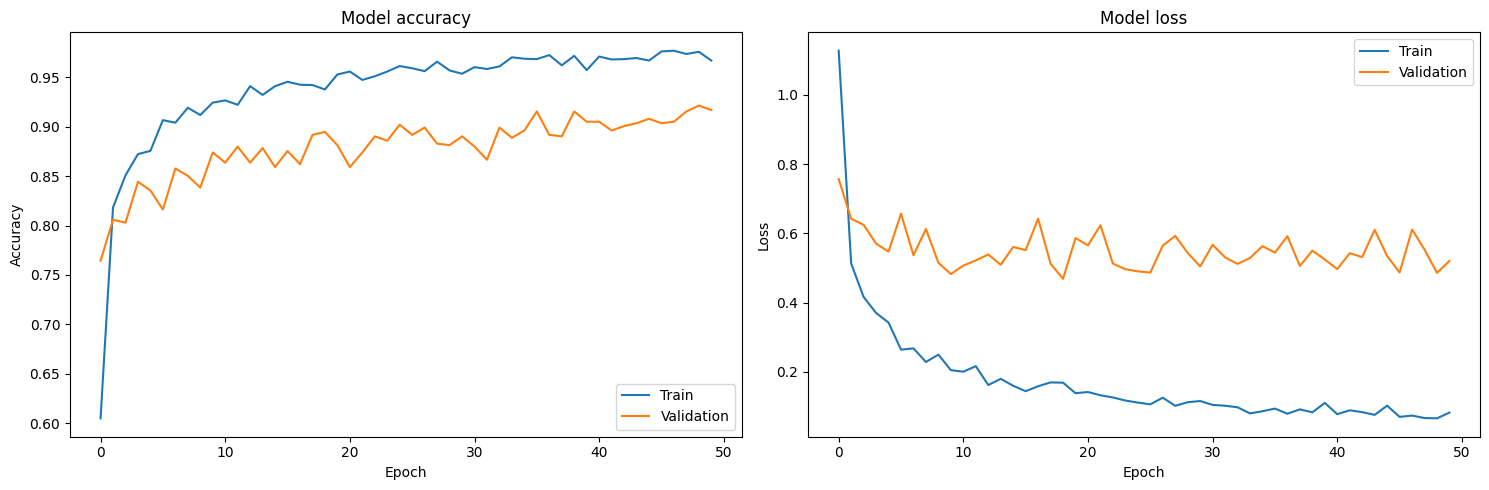

In [36]:
plot_training_history(history)

In [1]:
plot_training_history(history_fine)

NameError: name 'plot_training_history' is not defined

In [ ]:
def predict_soil(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    
    prediction = model.predict(img_array)
    soil_types = list(train_generator.class_indices.keys())
    predicted_class = soil_types[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    return predicted_class, confidence

In [ ]:
# class_name, confidence = predict_soil('image.jpg')
# print(f"Predicted soil type: {class_name}")
# print(f"Confidence: {confidence:.2f}%")

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50  
NUM_CLASSES = 8

In [9]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [11]:
full_dataset = datasets.ImageFolder(root='/kaggle/input/soil-types/Balanced Dataset', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
model = models.densenet121(pretrained=True)

In [13]:
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

In [14]:
for param in model.features.parameters():
    param.requires_grad = False

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [15]:
early_stopping_patience = 15
best_val_acc = 0
early_stopping_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_acc = val_correct / val_total
    
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Save final model after initial training
torch.save(model.state_dict(), 'final_initial_model.pth')

Epoch 1/50, Loss: 1.1156, Train Acc: 0.6199, Val Acc: 0.7914
Epoch 2/50, Loss: 0.6320, Train Acc: 0.7794, Val Acc: 0.8432
Epoch 3/50, Loss: 0.5463, Train Acc: 0.8009, Val Acc: 0.8639
Epoch 4/50, Loss: 0.5133, Train Acc: 0.8153, Val Acc: 0.8772
Epoch 5/50, Loss: 0.5369, Train Acc: 0.8038, Val Acc: 0.8713
Epoch 6/50, Loss: 0.4386, Train Acc: 0.8512, Val Acc: 0.8757
Epoch 7/50, Loss: 0.4451, Train Acc: 0.8360, Val Acc: 0.8624
Epoch 8/50, Loss: 0.4012, Train Acc: 0.8597, Val Acc: 0.8979
Epoch 9/50, Loss: 0.3708, Train Acc: 0.8642, Val Acc: 0.9009
Epoch 10/50, Loss: 0.3475, Train Acc: 0.8657, Val Acc: 0.9053
Epoch 11/50, Loss: 0.3499, Train Acc: 0.8768, Val Acc: 0.9172
Epoch 12/50, Loss: 0.3581, Train Acc: 0.8738, Val Acc: 0.9216
Epoch 13/50, Loss: 0.3105, Train Acc: 0.8845, Val Acc: 0.9127
Epoch 14/50, Loss: 0.3227, Train Acc: 0.8871, Val Acc: 0.9157
Epoch 15/50, Loss: 0.3192, Train Acc: 0.8830, Val Acc: 0.9290
Epoch 16/50, Loss: 0.2877, Train Acc: 0.8905, Val Acc: 0.9216
Epoch 17/50, Loss

In [16]:
for param in model.features[-4:].parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Fine-tuning training loop
best_val_acc_fine = 0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_acc = val_correct / val_total
    
    print(f'Fine-Tuning Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_acc > best_val_acc_fine:
        best_val_acc_fine = val_acc
        torch.save(model.state_dict(), 'best_fine_tuned_model.pth')

Fine-Tuning Epoch 1/50, Loss: 0.1920, Train Acc: 0.9304, Val Acc: 0.9645
Fine-Tuning Epoch 2/50, Loss: 0.1365, Train Acc: 0.9515, Val Acc: 0.9615
Fine-Tuning Epoch 3/50, Loss: 0.1259, Train Acc: 0.9611, Val Acc: 0.9749
Fine-Tuning Epoch 4/50, Loss: 0.0956, Train Acc: 0.9663, Val Acc: 0.9778
Fine-Tuning Epoch 5/50, Loss: 0.0898, Train Acc: 0.9674, Val Acc: 0.9675
Fine-Tuning Epoch 6/50, Loss: 0.1067, Train Acc: 0.9626, Val Acc: 0.9867
Fine-Tuning Epoch 7/50, Loss: 0.0736, Train Acc: 0.9759, Val Acc: 0.9808
Fine-Tuning Epoch 8/50, Loss: 0.0610, Train Acc: 0.9796, Val Acc: 0.9867
Fine-Tuning Epoch 9/50, Loss: 0.0704, Train Acc: 0.9774, Val Acc: 0.9822
Fine-Tuning Epoch 10/50, Loss: 0.0565, Train Acc: 0.9811, Val Acc: 0.9822
Fine-Tuning Epoch 11/50, Loss: 0.0709, Train Acc: 0.9726, Val Acc: 0.9837
Fine-Tuning Epoch 12/50, Loss: 0.0575, Train Acc: 0.9782, Val Acc: 0.9808
Fine-Tuning Epoch 13/50, Loss: 0.0551, Train Acc: 0.9804, Val Acc: 0.9749
Fine-Tuning Epoch 14/50, Loss: 0.0499, Train Ac

In [17]:
torch.save(model.state_dict(), 'final_fine_tuned_model.pth')